### 1. Intrinsic Calibration.
 
Use OpenCV to calibrate camera intrinsic parameters. Frames are saved in `intrinsic_calib_frames/[0-8]` folder. Cameras labeled by number 0-8, always start from `0`.Intrinsic can be used all the time and you don't need to run this part every time. 

How to get a checkboard?
- Use the `chessboard_11x8_20mm_onA4.jpg`. The board_size = (11,8), but the square_size won't be the exact `20.0mm`, it's around `19.5mm` to `20.5mm` depend on your printer.
- Buy in taobao.com (RECOMMAND). It's very precise. [棋盘格 氧化铝标定板](https://item.taobao.com/item.htm?spm=a21n57.1.0.0.2699523cr0RQDF&id=558737448467&ns=1&abbucket=0#detail)

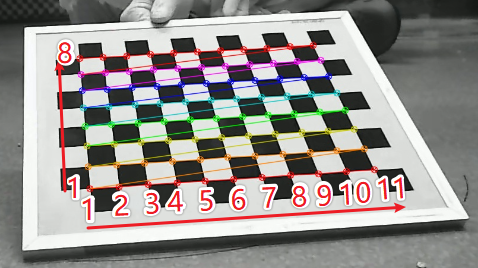


In [ ]:
import sys
sys.path.append(r'G:\Li_lab\lst_3d\calibration\multiview_ball_calib\1_intrinsic_calib')
import json
from intrinsic_utils import calibration, calibrate_nview

intrinsic_dir = r'G:\Li_lab\lst_3d\calibration\looming_lyj\intrinsic_calib_frames'
board_size = (11,8)  # checkerboard joints size
K, dist, image_HW = calibration(intrinsic_dir+'/3', board_size)# Calibrate one camera view
calibrate_nview(intrinsic_dir, board_size)  # Calibrate all [0-8] camera views. And export to json


The Intrinsic result is savedinto `intrinsic_calib_frames/intrinsics_calib.json`

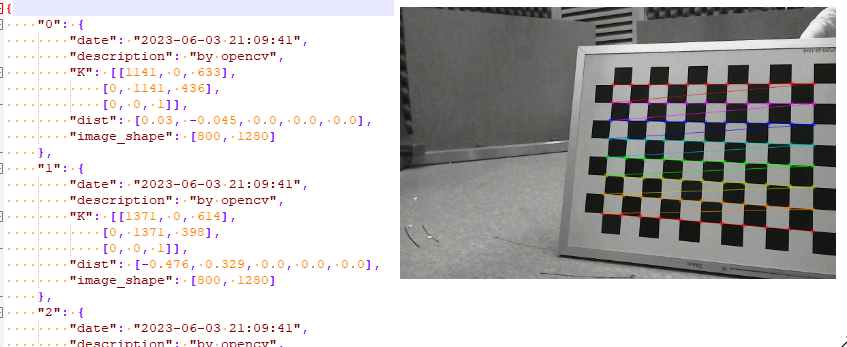

In [ ]:
intrinsics_data = json.load(open(intrinsic_dir+'/intrinsics_calib.json'))  # The Intrinsic result is saved.
print(intrinsics_data.keys())
intrinsics_data['3']

The default `dist` calibrate ignore the `tangential` and the `K3` distortion, which may suitable because modern camera is great enough, just a slight distortion. That's what MATLAB behave.

However, when you have `extreme` camerea distortion. Try to set the full distortion calibrating as below.
```python
#intrinsic_utils.py calibration()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
```

### 2. Extrinsic Calibration.

Pre-request, you have run step1 intrinsic calibration. The `intrinsics_calib.json` is previous outcome.


#### 2.1 Extract frames and use `labelme` to label single ball.

You need to label one point only `ball` in all images.
See more information in [labelme](https://github.com/wkentaro/labelme).

In [ ]:
import sys
import os
import cv2
sys.path.append(r'G:\Li_lab\lst_3d\calibration')
project_dir = r'G:\Li_lab\lst_3d\calibration\looming_lyj'

def extract_frames_4labelme(project_dir, max_frames, interval_frames, num_cam):
    output_folder = os.path.join(project_dir, 'ball_label')
    num_cam = 5
    video_files = [os.path.join(project_dir, f"{i}.avi") for i in range(1, num_cam+1)]
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_files[0])
    NumFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # frame_rate = cap.get(cv2.CAP_PROP_FPS)
    # frame_indices = np.array(range(0, frame_count-1, frame_rate))

    for video_file in video_files:
        cap = cv2.VideoCapture(video_file)
        frame_count = 0
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            cam_index = os.path.splitext(os.path.basename(video_file))[0]
            frame_filename = os.path.join(output_folder, f'cam{cam_index}_{frame_number:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            frame_count += 1
            for _ in range(interval_frames):
                cap.read()
        cap.release()
        print(f'{video_file} has been extracted.')
    jpg_count = 0
    for filename in os.listdir(output_folder):
        _, ext = os.path.splitext(filename)
        if ext.lower() == '.jpg':
            jpg_count += 1
    print(f'all {jpg_count} extracted frames are saved in {output_folder}.')
    
extract_frames_4labelme(project_dir, max_frames=100, interval_frames=15, num_cam=5)

#### 2.2 After label, you need to get `ball.matpkl` file.

After label all images, you can see every image has a corresponding `.json` file. You can use the following code to get the `ball.matpkl` file.

In [ ]:
import os
import pickle
import glob
import numpy as np
project_dir = r'G:\Li_lab\lst_3d\calibration\looming_lyj'
labelme_dir = os.path.join(project_dir, 'ball_label')
intrinsics_json = r"G:\Li_lab\lst_3d\calibration\looming_lyj\intrinsic_calib_frames\intrinsics_calib.json"

def convert_labelme2ball(labelme_dir, intrinsic_json):
    labelme_files = glob.glob(os.path.join(labelme_dir, '*.json'))
    labelme_file_nakes = [os.path.splitext(os.path.basename(f))[0] for f in labelme_files]
    
    cam_frameid = np.array([(int(f[-6]), int(f[-4:])) for f in labelme_file_nakes])
    cam_frameid[:,0] -= cam_frameid[:,0].min()
    
    intrinsic_data = json.load(open(intrinsic_json, 'r'))
    views_hw_shape = np.array([intrinsic_data[str(i)]['image_shape'] for i in range(len(intrinsic_data))])
    
    frameid = cam_frameid[:,1]
    nframe = len(set(frameid))
    ncam = len(set(cam_frameid[:,0]))
    frameid_dict = dict(zip(set(frameid), range(len(set(frameid)))))
    frame_reid = np.array([frameid_dict[letter] for letter in frameid])
    
    cam_frameid_re = cam_frameid.copy()
    cam_frameid_re[:,1] = frame_reid
    keypoints = np.zeros((ncam, nframe, 1, 3))
    keypoints[...,:2] = np.nan
    
    for camid, frame_reid_, labelme_file in zip(cam_frameid_re[:,0], cam_frameid_re[:,1], labelme_files):
        coco_data = json.load(open(labelme_file, 'r'))
        ball_xy_resize = np.array(coco_data['shapes'][0]['points'][0])
        resizeHW = np.array([coco_data['imageHeight'], coco_data['imageWidth']])
        ball_xy_ = ball_xy_resize / resizeHW[::-1] * views_hw_shape[camid][::-1]
        keypoints[camid, frame_reid_, 0] = [*ball_xy_, 1]
    
    info = {
        'nview': ncam, 
        'fps': 20
    }
    
    views_xywh = np.zeros((ncam, 4), dtype=int)
    views_xywh[:,2:] = views_hw_shape[:,::-1]
    outdict = { 'keypoints': keypoints,
                'info': info,
                'views_xywh': views_xywh
    }
    
    pickle.dump(outdict, open(os.path.join(labelme_dir, 'ball.matpkl'), 'wb'))
    print(f'ball.matpkl saved in {labelme_dir}.' )

convert_labelme2ball(labelme_dir, intrinsics_json)

The ball position in all view is stored in a `keypoints` variable, which is (NVIEW, NSAMPLE, NKEYPOINT=1, XYP=3).

And the `P` in `XYP` is **0<=P<=1**, means the reliable of this detection. If you failed to detect a ball sometimes in a view, just set the `XY=np.nan`, and `P=0` for **IVIEW**. The `P` will be cutoff around `0.7` to auto delete reliable ball detections.

In [ ]:
matfile = os.path.join(labelme_dir, 'ball.matpkl')
matdata = pickle.load(open(matfile, 'rb'))
assert 'keypoints' in matdata.keys()

print(matdata['keypoints'].shape) #(NVIEW, NSAMPLE, NKEYPOINT=1, xyp=3)
print(matdata['info'])            # The grid video. If you video is not grid. Just keep 'nview', 'fps'
print(matdata['views_xywh'])      # (NVIEW, 4) x,y,w,h. If you video is not grid in mycase, you just set x=0,y=0

#### 2.3 Create a multiview tree.

Here is to set the `connectivity` between cameras. Give the hint which pairs of cameras are likely share/(connectivity) most views field of ball. In general case, all cameras share most common view field. You can use default config. 

For example, `0` share with `2`, `0` not with `1`, `1` share with `2`. You can set `"minimal_tree":{[0, 2], [1, 2]}` to global connection.

Note that this `connectivity` define only works when calibration, and won't affect next step 2D<->3D transfrom.

In [ ]:
nview=len(matdata['views_xywh'])
minimal_tree = [[i,i+1] for i in range(nview-1)]
setup_dict = {"views": list(range(nview)),
              "minimal_tree": minimal_tree}
setup_json = 'setup.json'
json.dump(setup_dict, open(setup_json, 'w'), indent=4)
print(setup_dict)

#### 2.4 Get `.ballpkl` file.

It will do
- Downsample ball sample to 1000
- Pack all nessary informtion into one file

In [ ]:
from matpkl2ballpkl import convert as convert_matpkl2ballpkl

setup_json = 'setup.json'
convert_matpkl2ballpkl(matfile, intrinsics_json, setup_json)

Content of `ballpkl`
- **setup**: copy from `setup.json`
- **intrinsics**: copy from `intrinsic_calib.json`
- **landmarks_move_xy**: downsample ball xy position, (NVIEW, 1000, XY)
- **background_img**: (NVIEW, )x(H,W,3) numpy array for background image each view, default not set
- *landmarks_global_xy*, *landmarks_global_cm*, *global_iframe*: obsoleted


In [ ]:
# Check .ballpkl
ballpklfile = matfile.replace('.matpkl', '.ballpkl')
ballpkl = pickle.load(open(ballpklfile, 'rb'))
print(ballpkl.keys())
print(ballpkl['landmarks_move_xy'].shape)
print(ballpkl['intrinsics'])

#### 2.5 Multiview extrinsic calibration.

The main precessing is :
1. Pair each two pair cameras in the `setup.json/mini_tree`.
2. Concat all views. Get a rough relative pose.
3. Remove outlier samples. Use bundle ajustment to refine relative poses.
The outcome is `*.calibpkl` file.

In [ ]:
from ballpkl2calibpkl import main_calibrate
calibpklfile = main_calibrate(ballpklfile, skip_global=True, skip_camera_intrinsic=True)

Content of the outcome `calibpkl` file
- **ba_poses**: all intrinsic & extrinsic parameters. `K` (3, 3), `dist`: (K1_K2_T1_T2_K3,), `t` (3,), `R` (3, 3)

In [ ]:
#%% Check .calibpkl
calibpkl = pickle.load(open(calibpklfile, 'rb'))
print(calibpkl.keys())

print('ba_poses', calibpkl['ba_poses'])
calibpkl['ba_poses'][0]

### 3. World Axes Registration.

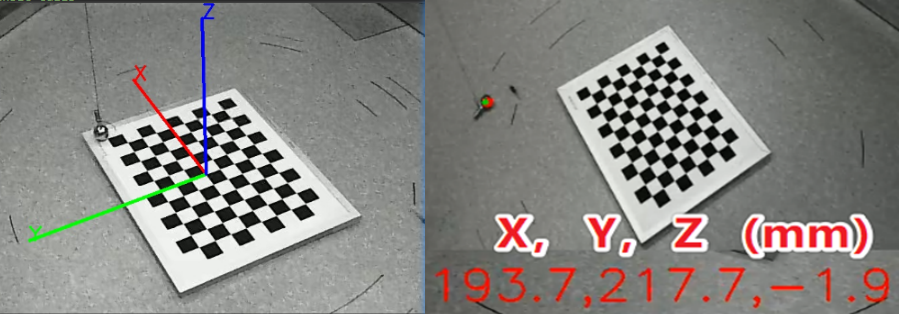

In [ ]:
import sys
sys.path.append(r'G:\Li_lab\lst_3d\calibration\\multiview_ball_calib\3_worldaxes_register')
import numpy as np
import p1_checkboard_global

board_size = (8, 11) # number of joints in the checkboard
square_size = 20  # millimeter in this case

#### 3.1 Detect the checkboard.

The result is saved in `demo_data`. The `origin point` and `axes direction` is shown/defined below.

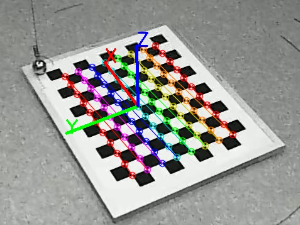

In [ ]:
global_img_folder = os.path.join(project_dir, 'global_register') # n view images
p1_checkboard_global.convert_from_img(global_img_folder, intrinsics_json, board_size, square_size)

In [ ]:
# Check the detected checkboard joints
import pickle
globalrefpkl = os.path.join(global_img_folder, 'calibration.globalrefpkl')
globalref = pickle.load(open(globalrefpkl, 'rb'))
print(globalref.keys())
print(globalref['keypoint_xyz'].shape) #njoint, xyz
print(globalref['keypoint_xy'].shape) #nview, njoint, xy

#### 3.3 Register multiview system to world axes.

In [ ]:
from p2_calibpkl_refine_byglobal import main as p2_main
import shutil
calibpkl = os.path.join(labelme_dir, 'ball.calibpkl')
recalibpkl = p2_main(calibpkl, globalrefpkl)

In [ ]:
multiview_calibpkl = os.path.join(project_dir, 'multiview_with_world_axes.calibpkl')
shutil.move(recalibpkl, multiview_calibpkl)
recalibpkl = multiview_calibpkl
recalib = pickle.load(open(recalibpkl, 'rb'))
print(recalib.keys())

#### 3.4 Change meta data in `.recalibpkl` file.

In [ ]:
import scipy.io as sio
import argparse
import os.path as osp
def convert(pklfile):
    data = pickle.load(open(pklfile, 'rb'))
    ba_poses = [data['ba_poses'][i] for i in range(len(data['ba_poses']))]
    image_shape = [2048, 2448]
    for item in ba_poses:
        item['image_shape'] = image_shape
    pklbytes = pickle.dumps({'ba_poses': data['ba_poses']})
    pklbytes_np = np.frombuffer(pklbytes, dtype=np.uint8)

    dataout = {'ba_poses': ba_poses, 'pklbytes': pklbytes_np}
    sio.savemat(pklfile + '.mat', dataout)
convert(recalibpkl)

### 4. 2D-3D Mutual Transformation.
Use command to make `.sync`` files of all cameras, which store the 2D-3D mutual transformation parameters.

```bash
python makeSyncFiles.py path_to_video_folder frame_rate num_landmarks
```
